In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

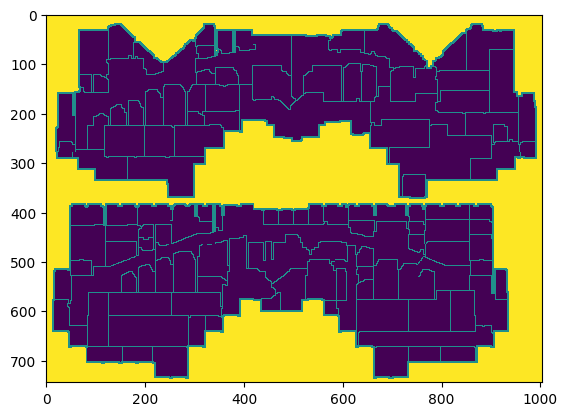

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with Grouped PCA...")

# ===== MODEL WITH GROUPED PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, components_per_group=15):
        self.use_gpu = use_gpu
        self.components_per_group = components_per_group
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.group_pcas = {}  # Will store PCA transformers for each group
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_groups = {}  # Will store feature group definitions
        self.exog_feature_names = None  # Will store original exogenous feature names
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def create_feature_groups(self, exog_data, exog_metadata_dict):
        """Create feature groups based on domain knowledge"""
        print("Creating feature groups based on domain knowledge...")
        
        # Initialize groups
        groups = {
            'air_temperatures': [],
            'water_temperatures': [],
            'setpoints': [],
            'control_commands': [],
            'environmental': [],
            'flow_pressure': [],
            'other': []
        }
        
        # Create feature names for mapping
        feature_names = []
        if isinstance(exog_metadata_dict, dict):
            # If we have the metadata mapping, use it
            name_to_idx = {name: idx for name, idx in exog_metadata_dict.items()}
            feature_names = list(name_to_idx.keys())
        else:
            # Create generic names
            feature_names = [f'feature_{i}' for i in range(exog_data.shape[1])]
        
        # Categorize features based on naming patterns
        for i, feature_name in enumerate(feature_names):
            name_lower = feature_name.lower()
            
            if any(keyword in name_lower for keyword in [
                'air_temperature', 'mixed_air_temperature', 
                'supply_air_temperature', 'return_air_temperature',
                'discharge_air_temperature', 'outside_air_temperature'
            ]):
                groups['air_temperatures'].append(i)
            
            elif any(keyword in name_lower for keyword in [
                'water_temperature', 'supply_water_temperature',
                'return_water_temperature', 'hot_water', 'chilled_water'
            ]):
                groups['water_temperatures'].append(i)
            
            elif any(keyword in name_lower for keyword in [
                'setpoint', '_setpoint', 'temperature_setpoint'
            ]):
                groups['setpoints'].append(i)
            
            elif any(keyword in name_lower for keyword in [
                'command', 'percentage_command', 'damper', 'fan_speed',
                'valve', 'position', 'cooling', 'heating'
            ]):
                groups['control_commands'].append(i)
            
            elif any(keyword in name_lower for keyword in [
                'outside_air', 'outdoor', 'ambient', 'humidity', 
                'dewpoint', 'wetbulb', 'pressure_sensor', 'static_pressure'
            ]):
                groups['environmental'].append(i)
            
            elif any(keyword in name_lower for keyword in [
                'flow', 'flowrate', 'pressure', 'static', 'differential'
            ]):
                groups['flow_pressure'].append(i)
            
            else:
                groups['other'].append(i)
        
        # Remove empty groups and store
        self.feature_groups = {name: indices for name, indices in groups.items() if len(indices) > 0}
        
        # Print group summary
        print("Feature groups created:")
        total_features = 0
        for group_name, indices in self.feature_groups.items():
            print(f"  {group_name}: {len(indices)} features")
            total_features += len(indices)
        print(f"  Total features categorized: {total_features}/{exog_data.shape[1]}")
        
        return self.feature_groups
    
    def fit_grouped_pca(self, exog_data, exog_metadata_dict):
        """Fit PCA separately for each feature group"""
        print(f"\nFitting Grouped PCA (max {self.components_per_group} components per group)...")
        
        # Create feature groups
        self.create_feature_groups(exog_data, exog_metadata_dict)
        
        total_components = 0
        
        for group_name, feature_indices in self.feature_groups.items():
            if len(feature_indices) == 0:
                continue
                
            # Extract group data
            group_data = exog_data[:, feature_indices]
            
            # Determine number of components (min of requested and available)
            n_components = min(self.components_per_group, len(feature_indices), group_data.shape[0]-1)
            
            if n_components <= 0:
                print(f"  Skipping {group_name}: insufficient data")
                continue
            
            # Fit PCA for this group
            group_pca = PCA(n_components=n_components, random_state=42)
            group_pca.fit(group_data)
            
            self.group_pcas[group_name] = group_pca
            
            explained_variance = np.sum(group_pca.explained_variance_ratio_)
            print(f"  {group_name}: {len(feature_indices)} features → {n_components} components "
                  f"(explained variance: {explained_variance:.3f})")
            
            total_components += n_components
        
        print(f"\nGrouped PCA Summary:")
        print(f"  Original features: {exog_data.shape[1]}")
        print(f"  Total PCA components: {total_components}")
        print(f"  Feature groups: {len(self.group_pcas)}")
        print(f"  Dimensionality reduction: {exog_data.shape[1]} → {total_components}")
    
    def transform_grouped_pca(self, exog_data):
        """Transform exogenous data using fitted grouped PCA"""
        if not self.group_pcas:
            raise ValueError("Grouped PCA not fitted yet. Call fit_grouped_pca first.")
        
        transformed_groups = []
        group_feature_names = []
        
        for group_name, group_pca in self.group_pcas.items():
            # Get feature indices for this group
            feature_indices = self.feature_groups[group_name]
            
            # Extract and transform group data
            group_data = exog_data[:, feature_indices]
            group_transformed = group_pca.transform(group_data)
            
            transformed_groups.append(group_transformed)
            
            # Create feature names for this group
            n_components = group_transformed.shape[1]
            group_names = [f'{group_name}_pc{i}' for i in range(n_components)]
            group_feature_names.extend(group_names)
        
        # Combine all transformed groups
        if transformed_groups:
            combined_transformed = np.hstack(transformed_groups)
        else:
            combined_transformed = np.array([]).reshape(exog_data.shape[0], 0)
        
        return combined_transformed, group_feature_names
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, Grouped PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and Grouped PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and not self.group_pcas:
                # Fit Grouped PCA on training data
                # We need the metadata dict for feature grouping
                exog_metadata = exogenous_observation_data_ids if 'exogenous_observation_data_ids' in globals() else None
                self.fit_grouped_pca(exog_data_clean, exog_metadata)
            
            # Transform exogenous data using Grouped PCA
            exog_pca, exog_names = self.transform_grouped_pca(exog_data_clean)
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create hourly bins for data"""
        hourly_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                hour = ts.hour
            else:  # Unix timestamp
                hour = datetime.fromtimestamp(ts).hour
                
            if hour not in hourly_data:
                hourly_data[hour] = {'X': [], 'y': []}
            hourly_data[hour]['X'].append(X[i])
            if y is not None:
                hourly_data[hour]['y'].append(y[i])
        
        # Convert to numpy arrays
        for hour in hourly_data:
            hourly_data[hour]['X'] = np.array(hourly_data[hour]['X'])
            if y is not None:
                hourly_data[hour]['y'] = np.array(hourly_data[hour]['y'])
        
        return hourly_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        return mean_absolute_error(y_val, y_pred)
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=5):
        """Train 24 hourly XGBoost models with hyperparameter optimization"""
        
        # Create hourly bins
        hourly_train_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(hourly_train_data)} hourly models...")
        
        for hour in range(24):
            if hour not in hourly_train_data:
                print(f"No data for hour {hour}, skipping...")
                continue
                
            print(f"Training model for hour {hour}...")
            
            X_hour = hourly_train_data[hour]['X']
            y_hour = hourly_train_data[hour]['y']
            
            if len(X_hour) < 10:
                print(f"Too few samples for hour {hour} ({len(X_hour)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_hour_scaled = scaler.fit_transform(X_hour)
            self.scalers[hour] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'hour_{hour}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_hour_scaled, y_hour, trial)
            
            study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            
            # Train final model with best parameters
            best_params = study.best_params
            best_params.update({
                'objective': 'reg:absoluteerror',
                'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                'random_state': 42,
                'n_jobs': 1
            })
            
            base_model = xgb.XGBRegressor(**best_params)
            model = MultiOutputRegressor(base_model, n_jobs=1)
            model.fit(X_hour_scaled, y_hour)
            
            self.models[hour] = model
            
            print(f"Hour {hour} - Best MAE: {study.best_value:.4f}")
        
        print(f"Training completed. {len(self.models)} models trained.")
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using hourly models"""
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create hourly bins for test data
        hourly_test_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for hour in hourly_test_data:
            if hour not in self.models:
                available_hours = list(self.models.keys())
                hour_to_use = min(available_hours, key=lambda x: abs(x - hour))
                print(f"Using model for hour {hour_to_use} instead of hour {hour}")
            else:
                hour_to_use = hour
            
            X_hour = hourly_test_data[hour]['X']
            X_hour_scaled = self.scalers[hour_to_use].transform(X_hour)
            
            hour_predictions = self.models[hour_to_use].predict(X_hour_scaled)
            
            # Map predictions back to original indices
            hour_indices = []
            for i, ts in enumerate(timestamps_test):
                if hasattr(ts, 'hour'):
                    ts_hour = ts.hour
                else:
                    ts_hour = datetime.fromtimestamp(ts).hour
                    
                if ts_hour == hour:
                    hour_indices.append(i)
            
            for i, idx in enumerate(hour_indices):
                predictions[idx] = hour_predictions[i]
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    print("Initializing Smart Buildings Predictor with Grouped PCA...")
    predictor = SmartBuildingsPredictor(use_gpu=True, components_per_group=15)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=5)
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-06 02:13:11,893] A new study created in memory with name: hour_0


Training data shape: X=(35502, 119), y=(35502, 123)
Feature names: 119 features
Training 24 hourly models...
Training model for hour 0...


[I 2025-07-06 02:14:35,674] Trial 0 finished with value: 1.428215325055329 and parameters: {'n_estimators': 105, 'max_depth': 7, 'learning_rate': 0.29486705746568753, 'subsample': 0.7119674331203699, 'colsample_bytree': 0.7910763321709807, 'reg_alpha': 3.686206610809941, 'reg_lambda': 5.05254228906335}. Best is trial 0 with value: 1.428215325055329.
[I 2025-07-06 02:16:38,950] Trial 1 finished with value: 1.3837706938000678 and parameters: {'n_estimators': 148, 'max_depth': 7, 'learning_rate': 0.24717934899140243, 'subsample': 0.7784571663986545, 'colsample_bytree': 0.8430620458232236, 'reg_alpha': 2.6697309223623917, 'reg_lambda': 6.436853529573526}. Best is trial 1 with value: 1.3837706938000678.
[I 2025-07-06 02:21:32,379] Trial 2 finished with value: 1.4047803025598944 and parameters: {'n_estimators': 412, 'max_depth': 7, 'learning_rate': 0.29485666312161224, 'subsample': 0.8898400035230203, 'colsample_bytree': 0.6822745735855745, 'reg_alpha': 2.02485015629368, 'reg_lambda': 0.3885

Hour 0 - Best MAE: 1.3838
Training model for hour 1...


[I 2025-07-06 02:31:44,395] Trial 0 finished with value: 1.621796654430736 and parameters: {'n_estimators': 448, 'max_depth': 5, 'learning_rate': 0.29305277760890064, 'subsample': 0.7892676406213743, 'colsample_bytree': 0.9319758143520563, 'reg_alpha': 6.573066392741979, 'reg_lambda': 1.3153940174382575}. Best is trial 0 with value: 1.621796654430736.
[I 2025-07-06 02:32:36,076] Trial 1 finished with value: 1.7561669697920426 and parameters: {'n_estimators': 101, 'max_depth': 5, 'learning_rate': 0.17449893717307072, 'subsample': 0.7050270517347372, 'colsample_bytree': 0.9745681864431287, 'reg_alpha': 6.859838154648385, 'reg_lambda': 4.455768619658992}. Best is trial 0 with value: 1.621796654430736.
[I 2025-07-06 02:36:04,254] Trial 2 finished with value: 1.7519469595310355 and parameters: {'n_estimators': 285, 'max_depth': 7, 'learning_rate': 0.046410152607344865, 'subsample': 0.9055830447685294, 'colsample_bytree': 0.607204479573222, 'reg_alpha': 4.866088109351316, 'reg_lambda': 8.178

Hour 1 - Best MAE: 1.4871
Training model for hour 2...


[I 2025-07-06 02:59:27,266] Trial 0 finished with value: 1.6947477624234255 and parameters: {'n_estimators': 440, 'max_depth': 6, 'learning_rate': 0.06741321443770114, 'subsample': 0.8438924170927966, 'colsample_bytree': 0.6202959229418231, 'reg_alpha': 1.765034524914484, 'reg_lambda': 4.739931762935989}. Best is trial 0 with value: 1.6947477624234255.
[I 2025-07-06 03:00:33,651] Trial 1 finished with value: 1.910179911204716 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.07415816475769356, 'subsample': 0.8579011880945873, 'colsample_bytree': 0.7840945786569666, 'reg_alpha': 6.8678446152086385, 'reg_lambda': 5.764972750446067}. Best is trial 0 with value: 1.6947477624234255.
[I 2025-07-06 03:02:49,484] Trial 2 finished with value: 1.7038919103900472 and parameters: {'n_estimators': 303, 'max_depth': 5, 'learning_rate': 0.16191036114061394, 'subsample': 0.7767861344989363, 'colsample_bytree': 0.8438373935137256, 'reg_alpha': 1.8051542821575213, 'reg_lambda': 4.

Hour 2 - Best MAE: 1.5466
Training model for hour 3...


[I 2025-07-06 03:20:59,007] Trial 0 finished with value: 2.0097520777270867 and parameters: {'n_estimators': 313, 'max_depth': 3, 'learning_rate': 0.07682085066472752, 'subsample': 0.8671997703186352, 'colsample_bytree': 0.9679588746520972, 'reg_alpha': 6.568030422573455, 'reg_lambda': 1.8484135185618875}. Best is trial 0 with value: 2.0097520777270867.
[I 2025-07-06 03:26:42,451] Trial 1 finished with value: 1.8674095029491309 and parameters: {'n_estimators': 457, 'max_depth': 7, 'learning_rate': 0.17156773379954854, 'subsample': 0.6255693085195742, 'colsample_bytree': 0.6406335202175243, 'reg_alpha': 0.1360687385335384, 'reg_lambda': 7.9375220397128885}. Best is trial 1 with value: 1.8674095029491309.
[I 2025-07-06 03:33:44,499] Trial 2 finished with value: 1.9851313386203138 and parameters: {'n_estimators': 497, 'max_depth': 7, 'learning_rate': 0.29919370624563246, 'subsample': 0.91284131362749, 'colsample_bytree': 0.8040188217226178, 'reg_alpha': 9.648602527465416, 'reg_lambda': 0.

Hour 3 - Best MAE: 1.8674
Training model for hour 4...


[I 2025-07-06 03:47:30,001] Trial 0 finished with value: 2.029502691675637 and parameters: {'n_estimators': 223, 'max_depth': 5, 'learning_rate': 0.06504325934544167, 'subsample': 0.7266628132971836, 'colsample_bytree': 0.9444815500530295, 'reg_alpha': 5.382005451125311, 'reg_lambda': 7.682264700581028}. Best is trial 0 with value: 2.029502691675637.
[I 2025-07-06 03:52:49,366] Trial 1 finished with value: 2.0824938804529616 and parameters: {'n_estimators': 322, 'max_depth': 8, 'learning_rate': 0.22136187119230866, 'subsample': 0.861394244513652, 'colsample_bytree': 0.6538249841384616, 'reg_alpha': 8.041691345994941, 'reg_lambda': 4.31827843024293}. Best is trial 0 with value: 2.029502691675637.
[I 2025-07-06 03:55:19,875] Trial 2 finished with value: 2.076256209471821 and parameters: {'n_estimators': 184, 'max_depth': 7, 'learning_rate': 0.26017407568843764, 'subsample': 0.6975362107336072, 'colsample_bytree': 0.7115699512468684, 'reg_alpha': 6.658900160717305, 'reg_lambda': 1.4969019

Hour 4 - Best MAE: 1.8937
Training model for hour 5...


[I 2025-07-06 04:04:57,121] Trial 0 finished with value: 1.8059192604074916 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.2330845684466652, 'subsample': 0.9461146219435568, 'colsample_bytree': 0.7625012812401979, 'reg_alpha': 6.3831184481910155, 'reg_lambda': 9.347169200527095}. Best is trial 0 with value: 1.8059192604074916.
[I 2025-07-06 04:11:48,321] Trial 1 finished with value: 1.7318304141853202 and parameters: {'n_estimators': 453, 'max_depth': 7, 'learning_rate': 0.09555421844978008, 'subsample': 0.9574113953316251, 'colsample_bytree': 0.9583522000103234, 'reg_alpha': 6.547421920709712, 'reg_lambda': 5.207981725655977}. Best is trial 1 with value: 1.7318304141853202.
[I 2025-07-06 04:15:25,501] Trial 2 finished with value: 1.9615050366921263 and parameters: {'n_estimators': 266, 'max_depth': 8, 'learning_rate': 0.02349846131233146, 'subsample': 0.881468223303246, 'colsample_bytree': 0.6430883199701947, 'reg_alpha': 2.3216257411592056, 'reg_lambda': 4.4

Hour 5 - Best MAE: 1.7318
Training model for hour 6...


[I 2025-07-06 04:29:27,682] Trial 0 finished with value: 1.5946223373061743 and parameters: {'n_estimators': 299, 'max_depth': 4, 'learning_rate': 0.15274858551674475, 'subsample': 0.7669846345037633, 'colsample_bytree': 0.7796886799241077, 'reg_alpha': 1.5035276103565005, 'reg_lambda': 1.560017424323066}. Best is trial 0 with value: 1.5946223373061743.
[I 2025-07-06 04:30:24,822] Trial 1 finished with value: 1.6472372669235371 and parameters: {'n_estimators': 208, 'max_depth': 3, 'learning_rate': 0.1484805035544387, 'subsample': 0.6221294997417199, 'colsample_bytree': 0.757861767705355, 'reg_alpha': 1.1645768076114766, 'reg_lambda': 6.882275664291068}. Best is trial 0 with value: 1.5946223373061743.
[I 2025-07-06 04:36:41,288] Trial 2 finished with value: 1.5993277085111401 and parameters: {'n_estimators': 415, 'max_depth': 7, 'learning_rate': 0.18742352325261064, 'subsample': 0.9598755440774616, 'colsample_bytree': 0.854614671902589, 'reg_alpha': 2.1856176020006797, 'reg_lambda': 3.8

Hour 6 - Best MAE: 1.5946
Training model for hour 7...


[I 2025-07-06 04:49:06,509] Trial 0 finished with value: 1.8667231662352899 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.19804473765608602, 'subsample': 0.797631837061213, 'colsample_bytree': 0.6610536616731458, 'reg_alpha': 7.927476965834872, 'reg_lambda': 8.641316863471195}. Best is trial 0 with value: 1.8667231662352899.
[I 2025-07-06 04:50:52,007] Trial 1 finished with value: 1.8607205580011692 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.055401024205836064, 'subsample': 0.831637784418218, 'colsample_bytree': 0.7210576468242563, 'reg_alpha': 7.49851176606486, 'reg_lambda': 0.4189420996625306}. Best is trial 1 with value: 1.8607205580011692.
[I 2025-07-06 04:53:19,700] Trial 2 finished with value: 1.689483050035183 and parameters: {'n_estimators': 421, 'max_depth': 4, 'learning_rate': 0.05849379810453526, 'subsample': 0.6741607604653513, 'colsample_bytree': 0.8980281427968928, 'reg_alpha': 2.9989452700289974, 'reg_lambda': 4.63

Hour 7 - Best MAE: 1.6895
Training model for hour 8...


[I 2025-07-06 05:01:28,706] Trial 0 finished with value: 1.7380934636704468 and parameters: {'n_estimators': 207, 'max_depth': 6, 'learning_rate': 0.08191116165704444, 'subsample': 0.706184946791576, 'colsample_bytree': 0.9217217118469836, 'reg_alpha': 0.26723059875662913, 'reg_lambda': 8.148659415792388}. Best is trial 0 with value: 1.7380934636704468.
[I 2025-07-06 05:06:23,479] Trial 1 finished with value: 1.7686143431243688 and parameters: {'n_estimators': 299, 'max_depth': 7, 'learning_rate': 0.29640716615813906, 'subsample': 0.7521001912417988, 'colsample_bytree': 0.9622623935950652, 'reg_alpha': 4.11709862158999, 'reg_lambda': 8.56050979527538}. Best is trial 0 with value: 1.7380934636704468.
[I 2025-07-06 05:10:28,684] Trial 2 finished with value: 1.8119254204432964 and parameters: {'n_estimators': 318, 'max_depth': 7, 'learning_rate': 0.05488189515889396, 'subsample': 0.73255660446535, 'colsample_bytree': 0.8509882194421472, 'reg_alpha': 9.166454690377849, 'reg_lambda': 0.6870

Hour 8 - Best MAE: 1.7381
Training model for hour 9...


[I 2025-07-06 05:19:47,062] Trial 0 finished with value: 1.7778088390608795 and parameters: {'n_estimators': 424, 'max_depth': 6, 'learning_rate': 0.09652565086967768, 'subsample': 0.7659093894807922, 'colsample_bytree': 0.7791988577268507, 'reg_alpha': 2.9514683471039365, 'reg_lambda': 7.863352097324488}. Best is trial 0 with value: 1.7778088390608795.
[I 2025-07-06 05:28:55,511] Trial 1 finished with value: 1.8482695923554544 and parameters: {'n_estimators': 481, 'max_depth': 8, 'learning_rate': 0.19947038074401377, 'subsample': 0.9838948442939278, 'colsample_bytree': 0.6711635690263706, 'reg_alpha': 4.654180192751143, 'reg_lambda': 3.552764832468544}. Best is trial 0 with value: 1.7778088390608795.
[I 2025-07-06 05:29:29,251] Trial 2 finished with value: 1.9480921958116983 and parameters: {'n_estimators': 111, 'max_depth': 3, 'learning_rate': 0.05596115996095143, 'subsample': 0.8605342249476946, 'colsample_bytree': 0.812546665584848, 'reg_alpha': 0.1048304159173529, 'reg_lambda': 2.

Hour 9 - Best MAE: 1.7466
Training model for hour 10...


[I 2025-07-06 05:45:54,368] Trial 0 finished with value: 2.034115663178539 and parameters: {'n_estimators': 371, 'max_depth': 8, 'learning_rate': 0.29831357040845813, 'subsample': 0.6233251760935606, 'colsample_bytree': 0.8045858835949934, 'reg_alpha': 7.0336334066989545, 'reg_lambda': 5.845597909229907}. Best is trial 0 with value: 2.034115663178539.
[I 2025-07-06 05:46:46,739] Trial 1 finished with value: 2.0339484277961817 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.046155438716028986, 'subsample': 0.8236861422864927, 'colsample_bytree': 0.8747747474201066, 'reg_alpha': 7.897984020167945, 'reg_lambda': 1.3045925284543303}. Best is trial 1 with value: 2.0339484277961817.
[I 2025-07-06 05:49:29,637] Trial 2 finished with value: 1.8739108163775837 and parameters: {'n_estimators': 354, 'max_depth': 5, 'learning_rate': 0.05137575615280548, 'subsample': 0.8665447564058603, 'colsample_bytree': 0.8376221507201735, 'reg_alpha': 0.08588967743081476, 'reg_lambda': 

Hour 10 - Best MAE: 1.8739
Training model for hour 11...


[I 2025-07-06 05:59:21,757] Trial 0 finished with value: 1.9887003370243408 and parameters: {'n_estimators': 479, 'max_depth': 4, 'learning_rate': 0.1612126802150458, 'subsample': 0.8662009089117677, 'colsample_bytree': 0.9499352704413383, 'reg_alpha': 3.5983803408779385, 'reg_lambda': 0.502777281987058}. Best is trial 0 with value: 1.9887003370243408.
[I 2025-07-06 06:02:35,255] Trial 1 finished with value: 2.0751038689464396 and parameters: {'n_estimators': 413, 'max_depth': 5, 'learning_rate': 0.14847927122386373, 'subsample': 0.9088216884999812, 'colsample_bytree': 0.7522202918755516, 'reg_alpha': 3.7755430694534193, 'reg_lambda': 4.96197302714883}. Best is trial 0 with value: 1.9887003370243408.
[I 2025-07-06 06:03:36,531] Trial 2 finished with value: 2.154832168749678 and parameters: {'n_estimators': 218, 'max_depth': 3, 'learning_rate': 0.24186400745707692, 'subsample': 0.6336316214314238, 'colsample_bytree': 0.6956772753459675, 'reg_alpha': 7.0455096163178395, 'reg_lambda': 9.3

Hour 11 - Best MAE: 1.9887
Training model for hour 12...


[I 2025-07-06 06:22:20,596] Trial 0 finished with value: 2.669803995708106 and parameters: {'n_estimators': 267, 'max_depth': 7, 'learning_rate': 0.15558332099177552, 'subsample': 0.7849014189220331, 'colsample_bytree': 0.8694735694633351, 'reg_alpha': 6.518389899672548, 'reg_lambda': 1.3697063697199614}. Best is trial 0 with value: 2.669803995708106.
[I 2025-07-06 06:23:51,593] Trial 1 finished with value: 2.691546286172226 and parameters: {'n_estimators': 149, 'max_depth': 6, 'learning_rate': 0.19688835451475004, 'subsample': 0.6091279653038345, 'colsample_bytree': 0.7345572534444831, 'reg_alpha': 0.18775035207258514, 'reg_lambda': 6.531645385150081}. Best is trial 0 with value: 2.669803995708106.
[I 2025-07-06 06:29:18,746] Trial 2 finished with value: 3.12916733788572 and parameters: {'n_estimators': 342, 'max_depth': 8, 'learning_rate': 0.0987372367120699, 'subsample': 0.8673218948960233, 'colsample_bytree': 0.6178938299166181, 'reg_alpha': 7.081730316328106, 'reg_lambda': 4.90084

Hour 12 - Best MAE: 2.6392
Training model for hour 13...


[I 2025-07-06 06:44:16,624] Trial 0 finished with value: 2.084970950062583 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.195996752566241, 'subsample': 0.8892310001221211, 'colsample_bytree': 0.9636334480808656, 'reg_alpha': 3.4690385752021315, 'reg_lambda': 5.615009755360443}. Best is trial 0 with value: 2.084970950062583.
[I 2025-07-06 06:45:46,779] Trial 1 finished with value: 2.0708983910533956 and parameters: {'n_estimators': 248, 'max_depth': 4, 'learning_rate': 0.13667366281470267, 'subsample': 0.8829824661547884, 'colsample_bytree': 0.9585475496236425, 'reg_alpha': 2.0535757283831915, 'reg_lambda': 8.639499189873439}. Best is trial 1 with value: 2.0708983910533956.
[I 2025-07-06 06:50:17,482] Trial 2 finished with value: 2.1172860652655046 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.15112742042327265, 'subsample': 0.6029452051430927, 'colsample_bytree': 0.895256496281422, 'reg_alpha': 7.258654185101637, 'reg_lambda': 0.6757

Hour 13 - Best MAE: 2.0709
Training model for hour 14...


[I 2025-07-06 06:57:07,073] Trial 0 finished with value: 1.6153838460038348 and parameters: {'n_estimators': 258, 'max_depth': 5, 'learning_rate': 0.2658949771684822, 'subsample': 0.7625057268690187, 'colsample_bytree': 0.7243125372914904, 'reg_alpha': 8.958582925133326, 'reg_lambda': 9.4173972111617}. Best is trial 0 with value: 1.6153838460038348.
[I 2025-07-06 06:58:24,683] Trial 1 finished with value: 2.0395056815152937 and parameters: {'n_estimators': 282, 'max_depth': 3, 'learning_rate': 0.01967110027583882, 'subsample': 0.9785898467970215, 'colsample_bytree': 0.9032835039831323, 'reg_alpha': 9.499729930057102, 'reg_lambda': 9.755069282930899}. Best is trial 0 with value: 1.6153838460038348.
[I 2025-07-06 07:00:11,685] Trial 2 finished with value: 1.4748321564048146 and parameters: {'n_estimators': 209, 'max_depth': 5, 'learning_rate': 0.21356104808604234, 'subsample': 0.8449192149966317, 'colsample_bytree': 0.9475466448848472, 'reg_alpha': 0.6935292674455269, 'reg_lambda': 7.760

Hour 14 - Best MAE: 1.4748
Training model for hour 15...


[I 2025-07-06 07:14:22,390] Trial 0 finished with value: 1.3338220639648977 and parameters: {'n_estimators': 439, 'max_depth': 7, 'learning_rate': 0.19177091800754045, 'subsample': 0.6571442026904694, 'colsample_bytree': 0.8965920418968104, 'reg_alpha': 3.277409902331912, 'reg_lambda': 9.003463754435797}. Best is trial 0 with value: 1.3338220639648977.
[I 2025-07-06 07:15:05,321] Trial 1 finished with value: 1.4984469084885323 and parameters: {'n_estimators': 144, 'max_depth': 3, 'learning_rate': 0.16450117189712438, 'subsample': 0.7672112822952922, 'colsample_bytree': 0.7585476513991395, 'reg_alpha': 6.305444989489367, 'reg_lambda': 4.453606289290347}. Best is trial 0 with value: 1.3338220639648977.
[I 2025-07-06 07:16:04,686] Trial 2 finished with value: 1.3198251097722513 and parameters: {'n_estimators': 152, 'max_depth': 4, 'learning_rate': 0.23106723333488768, 'subsample': 0.9061370757493835, 'colsample_bytree': 0.8442036480994052, 'reg_alpha': 6.167533182560983, 'reg_lambda': 8.9

Hour 15 - Best MAE: 1.3026
Training model for hour 16...


[I 2025-07-06 07:36:47,770] Trial 0 finished with value: 1.5796527361461907 and parameters: {'n_estimators': 408, 'max_depth': 8, 'learning_rate': 0.2983484128807289, 'subsample': 0.8774183313648494, 'colsample_bytree': 0.7985594716430385, 'reg_alpha': 1.6416289971493034, 'reg_lambda': 2.5191259633636944}. Best is trial 0 with value: 1.5796527361461907.
[I 2025-07-06 07:37:25,036] Trial 1 finished with value: 1.4959200762180418 and parameters: {'n_estimators': 120, 'max_depth': 3, 'learning_rate': 0.17877787769881875, 'subsample': 0.9938768781771534, 'colsample_bytree': 0.9398144061606423, 'reg_alpha': 8.935623643985409, 'reg_lambda': 0.8977760274202519}. Best is trial 1 with value: 1.4959200762180418.
[I 2025-07-06 07:42:36,367] Trial 2 finished with value: 1.5787687575590965 and parameters: {'n_estimators': 292, 'max_depth': 8, 'learning_rate': 0.23827332905193238, 'subsample': 0.8402333880702055, 'colsample_bytree': 0.7509765860345863, 'reg_alpha': 8.88660790563363, 'reg_lambda': 7.

Hour 16 - Best MAE: 1.4959
Training model for hour 17...


[I 2025-07-06 07:53:24,867] Trial 0 finished with value: 1.5185805003758044 and parameters: {'n_estimators': 346, 'max_depth': 5, 'learning_rate': 0.21961176410046684, 'subsample': 0.6614526477308585, 'colsample_bytree': 0.8319716472351595, 'reg_alpha': 8.373273019229554, 'reg_lambda': 2.264825047899288}. Best is trial 0 with value: 1.5185805003758044.
[I 2025-07-06 07:55:25,072] Trial 1 finished with value: 1.633737121958332 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.2763846855610121, 'subsample': 0.9187863223849444, 'colsample_bytree': 0.6965717940259346, 'reg_alpha': 9.069443939064383, 'reg_lambda': 9.71211183246078}. Best is trial 0 with value: 1.5185805003758044.
[I 2025-07-06 07:57:36,546] Trial 2 finished with value: 1.5199691115547322 and parameters: {'n_estimators': 491, 'max_depth': 3, 'learning_rate': 0.04408761544507741, 'subsample': 0.9182625570172688, 'colsample_bytree': 0.8457377845044998, 'reg_alpha': 4.178741679231222, 'reg_lambda': 5.8821

Hour 17 - Best MAE: 1.5186
Training model for hour 18...


[I 2025-07-06 08:19:26,959] Trial 0 finished with value: 1.5333914485689817 and parameters: {'n_estimators': 387, 'max_depth': 8, 'learning_rate': 0.2027453330356101, 'subsample': 0.9763216022509652, 'colsample_bytree': 0.9446931724325209, 'reg_alpha': 9.313175242685517, 'reg_lambda': 0.07517485394738961}. Best is trial 0 with value: 1.5333914485689817.
[I 2025-07-06 08:20:30,047] Trial 1 finished with value: 1.5752270424401704 and parameters: {'n_estimators': 171, 'max_depth': 4, 'learning_rate': 0.14068659579216183, 'subsample': 0.7120928150607289, 'colsample_bytree': 0.741947959232676, 'reg_alpha': 8.198468036047636, 'reg_lambda': 9.686131494264787}. Best is trial 0 with value: 1.5333914485689817.
[I 2025-07-06 08:25:36,672] Trial 2 finished with value: 1.522773166484286 and parameters: {'n_estimators': 447, 'max_depth': 6, 'learning_rate': 0.19409587661752098, 'subsample': 0.6415177155001915, 'colsample_bytree': 0.9894420049767357, 'reg_alpha': 9.447259310673834, 'reg_lambda': 8.58

Hour 18 - Best MAE: 1.4907
Training model for hour 19...


[I 2025-07-06 08:33:48,075] Trial 0 finished with value: 1.5153418231096236 and parameters: {'n_estimators': 179, 'max_depth': 3, 'learning_rate': 0.11854546814035578, 'subsample': 0.9800795502337607, 'colsample_bytree': 0.9064892939186143, 'reg_alpha': 1.5314585576439694, 'reg_lambda': 1.310808255712167}. Best is trial 0 with value: 1.5153418231096236.
[I 2025-07-06 08:36:02,917] Trial 1 finished with value: 1.5120648079676007 and parameters: {'n_estimators': 490, 'max_depth': 3, 'learning_rate': 0.08741405756888979, 'subsample': 0.7354437425623163, 'colsample_bytree': 0.8982946324483557, 'reg_alpha': 8.958896525350834, 'reg_lambda': 6.995045519535005}. Best is trial 1 with value: 1.5120648079676007.
[I 2025-07-06 08:41:58,893] Trial 2 finished with value: 1.5065162611225043 and parameters: {'n_estimators': 287, 'max_depth': 8, 'learning_rate': 0.10107116245924101, 'subsample': 0.8285490343555721, 'colsample_bytree': 0.9962972597196438, 'reg_alpha': 5.832932036178206, 'reg_lambda': 7.

Hour 19 - Best MAE: 1.4849
Training model for hour 20...


[I 2025-07-06 08:56:13,514] Trial 0 finished with value: 1.5880910813919296 and parameters: {'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.2286133791427188, 'subsample': 0.8437295753394829, 'colsample_bytree': 0.7812214863023711, 'reg_alpha': 4.511759414986952, 'reg_lambda': 7.332138311814312}. Best is trial 0 with value: 1.5880910813919296.
[I 2025-07-06 08:57:30,629] Trial 1 finished with value: 1.581454320991006 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.28362657017671705, 'subsample': 0.818539416620677, 'colsample_bytree': 0.9211095389399587, 'reg_alpha': 2.530400526909483, 'reg_lambda': 6.086378692753491}. Best is trial 1 with value: 1.581454320991006.
[I 2025-07-06 09:00:19,515] Trial 2 finished with value: 1.5794868440494774 and parameters: {'n_estimators': 147, 'max_depth': 8, 'learning_rate': 0.25418051872210345, 'subsample': 0.9644880030899429, 'colsample_bytree': 0.8130460479202103, 'reg_alpha': 7.935351762098379, 'reg_lambda': 4.22155

Hour 20 - Best MAE: 1.5382
Training model for hour 21...


[I 2025-07-06 09:09:07,258] Trial 0 finished with value: 1.5198700984858802 and parameters: {'n_estimators': 271, 'max_depth': 4, 'learning_rate': 0.14826280988065593, 'subsample': 0.8041359535575802, 'colsample_bytree': 0.7315408164681018, 'reg_alpha': 5.080645279128086, 'reg_lambda': 2.6533191076222584}. Best is trial 0 with value: 1.5198700984858802.
[I 2025-07-06 09:10:26,201] Trial 1 finished with value: 1.7071099408193373 and parameters: {'n_estimators': 127, 'max_depth': 6, 'learning_rate': 0.0415014917136121, 'subsample': 0.8589371148616045, 'colsample_bytree': 0.7206095980420903, 'reg_alpha': 6.797010159616393, 'reg_lambda': 4.492974984109677}. Best is trial 0 with value: 1.5198700984858802.
[I 2025-07-06 09:11:18,574] Trial 2 finished with value: 1.4716091966732492 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.15770081503736796, 'subsample': 0.7117033178726728, 'colsample_bytree': 0.833775635552973, 'reg_alpha': 4.137425902886976, 'reg_lambda': 5.67

Hour 21 - Best MAE: 1.4716
Training model for hour 22...


[I 2025-07-06 09:19:04,551] Trial 0 finished with value: 1.5241588267130548 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.1471661345998365, 'subsample': 0.7352747278502849, 'colsample_bytree': 0.8255717757568461, 'reg_alpha': 0.797781669826483, 'reg_lambda': 0.6045233113682624}. Best is trial 0 with value: 1.5241588267130548.
[I 2025-07-06 09:21:19,483] Trial 1 finished with value: 1.5496845871721918 and parameters: {'n_estimators': 487, 'max_depth': 3, 'learning_rate': 0.07578165804488493, 'subsample': 0.6056779676229452, 'colsample_bytree': 0.948080559103299, 'reg_alpha': 2.230907187483302, 'reg_lambda': 9.979245238081257}. Best is trial 0 with value: 1.5241588267130548.
[I 2025-07-06 09:22:43,535] Trial 2 finished with value: 1.5873822963634359 and parameters: {'n_estimators': 242, 'max_depth': 4, 'learning_rate': 0.22340935016815855, 'subsample': 0.8489333909514478, 'colsample_bytree': 0.6900251084378249, 'reg_alpha': 0.6860371678579736, 'reg_lambda': 9.3

Hour 22 - Best MAE: 1.5180
Training model for hour 23...


[I 2025-07-06 09:37:59,359] Trial 0 finished with value: 1.7838171524991067 and parameters: {'n_estimators': 245, 'max_depth': 7, 'learning_rate': 0.018701346172571173, 'subsample': 0.6672661791840856, 'colsample_bytree': 0.7190484348019962, 'reg_alpha': 2.5803089084621433, 'reg_lambda': 1.256435748822521}. Best is trial 0 with value: 1.7838171524991067.
[I 2025-07-06 09:38:38,997] Trial 1 finished with value: 2.0675060256050237 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.01557468949439248, 'subsample': 0.8572885542052351, 'colsample_bytree': 0.843009368699337, 'reg_alpha': 5.401904447703317, 'reg_lambda': 4.335032476360563}. Best is trial 0 with value: 1.7838171524991067.
[I 2025-07-06 09:39:50,332] Trial 2 finished with value: 1.600730108529156 and parameters: {'n_estimators': 264, 'max_depth': 3, 'learning_rate': 0.1728474791070572, 'subsample': 0.7721216519897961, 'colsample_bytree': 0.6529491111105302, 'reg_alpha': 3.001700943224904, 'reg_lambda': 3.66

Hour 23 - Best MAE: 1.6006
Training completed. 24 models trained.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 119)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 2.2263
first_2_weeks: MAE = 2.2263
first_month: MAE = 3.0495
first_3_months: MAE = 1.9203
entire_period: MAE = 1.7875
